In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shapely.geometry as shg           # for finding intersection of 2 lines
from shapely.geometry import LineString  # for finding intersection of 2 lines
from itertools import chain   # chain two ranges together
import sys

#location of the csv file
location = "./paper_tests/wl2_13day.csv"
#location of the baseline csv file
baseline = "./paper_tests/baseline_wl2_13day.csv"

#words to the title of each figure
title1="baseline vs"
title2="less reliable memory"

#used for naming the figure's png files.
figGroup="paper_reg_change_1_"

#figure size
figSizeWidth=20
figSizeHeight=10

#number of subplots to include in each figure
subplots=3


/Users/ndebard/python_virtualenv_ndebard/lib/python3.8/site-packages/seaborn/categorical.py:1733: UserWarning: You passed a edgecolor/edgecolors ([(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.2980392156862745, 0.4470588235294118, 0.6901

AttributeError: 'AxesSubplot' object has no attribute 'map'

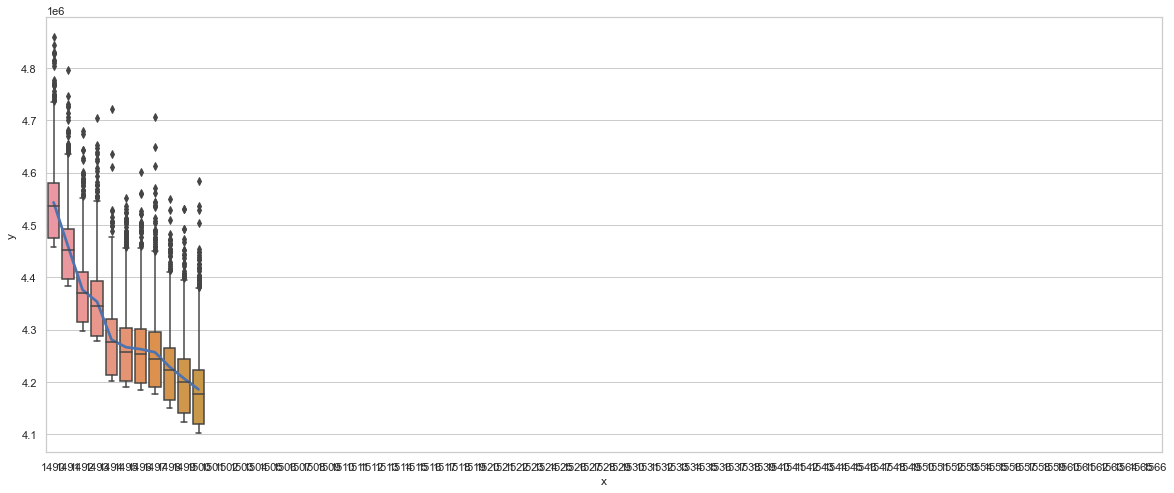

In [22]:
#this function rounds to the base.  ex: x=20.5 base=.5  return 20.5
#                                       x=20.3 base=.5  return 20.5
#                                       x=20.1 base=.5  return 20.0
def myround(x, base=1.0):
    return base * round(x/base)

#this function is used to check if we need a new figure (currently there are 3 subplots per figure)
#so if we are on our 4th plot we need a new figure and we need to save the old one.
def checkFig(*,row,figCount,fig=None,axs=None,rows=subplots):
    return row,figCount,fig,axs
    
    #if this is our first subplot in the figure we need a new figure
    if fig==None:
        fig,axs = plt.subplots(rows,1,figsize=(figSizeWidth,figSizeHeight*rows))
    #if the finished row equals the amount of subplots that are in a figure
    #then we need a new figure.  Save the figure, make a new one, and increase the figCount
    if row==subplots:
        fig.savefig(figGroup+"fig"+str(figCount)+".png",dpi=300)
        fig.savefig(figGroup+"fig"+str(figCount)+".pdf",dpi=300)
        fig,axs = plt.subplots(rows,1,figsize=(figSizeWidth,figSizeHeight*rows))
        figCount+=1
        return 0,figCount,fig,axs
    return row,figCount,fig,axs




#read in the baseline csv file
df_baseline = pd.read_csv(baseline,sep=",",header=0)

#save the baseline makespan
g = df_baseline["makespan_sec"].values[0]

#save the NMTBF of the baseline
baselineNMTBF=df_baseline["NMTBF"].values[0]

#read in the makespan data
df = pd.read_csv(location,sep=",",header=0)

#group the makespan data by NMTBF
groups = df.groupby(["NMTBF"])
#get the keys that are in the groups
myKeys=[key for key, _ in groups]
#sort the keys in reverse order
myKeys.sort(reverse=True)

#when you return df.groupby it has a weird datatype
#get the groups into a more functional dictionary
myGroups={}
for i in groups.groups.keys():
    myGroups[i]=groups.get_group(i)


# we want our graphs to look uniform so get the largest and smallest y values and the same with
# the x values so we can set each graph to have the same scale
largestY=0
smallestY=0
largestX=0
smallestX=0
for i in myKeys:
    myData=myGroups[i]
    theMaxY = myData["makespan_sec"].max()
    theMaxX = myData["nodes"].max()
    if theMaxY > largestY:
        largestY=theMaxY
    if theMaxX > largestX:
        largestX=theMaxX
    theMinY = myData["makespan_sec"].min()
    theMinX = myData["nodes"].min()
    if smallestY==0 or theMinY < smallestY:
        smallestY = theMinY
    if smallestX==0 or theMinX < smallestX:
        smallestX = theMinX


meanYPlots=[]
meanXPlots=[]
meanXPlotsFlt=[]
myXstr=[str(x) for x in list(np.arange(smallestX,largestX+1,1))]
myOrder=[str(x) for x in range(smallestX,largestX+1)]
myXflt=[np.float64(x) for x in list(np.arange(smallestX,largestX+1,1))]
intersections=[]
levels=[]
figCount=1
row=0
row,figCount,fig,axs=checkFig(row=row,figCount=figCount)
#fig.suptitle('Comparing Regular Grizzly Workloads With Increasingly Worse Memory Failures', y=.98,fontsize=28)

sns.set(rc={'figure.figsize':(20,8)})
sns.set_style("whitegrid")


for i in myKeys:
    row,figCount,fig,axs=checkFig(row=row,figCount=figCount,fig=fig,axs=axs)
    #put key in terms of 2x, 4x ...etc
    level = baselineNMTBF/np.float64(i)
    levels.append(level)
    myData = myGroups[i]
    myData = myData.sort_values(by="nodes").reset_index(drop=True)
    #get intersection
    m=myData.groupby("nodes")["makespan_sec"].mean()
    meanYPlots.append(m)
    meanXPlots.append(m.index)
    myBaseline=[g]*len(m.index)
    first_line = LineString(np.column_stack((m.index,m.values)))
    second_line = LineString(np.column_stack((m.index,myBaseline )))
    intersection = second_line.intersection(first_line)
    if intersection:
        if type(intersection)==shg.point.Point:
            intersections.append(intersection.xy)
        else:
            intersections.append(LineString(intersection).xy)
    
    
    
    x=[str(x) for x in myData["nodes"]]
    Xmin=myData["nodes"].min()
    Xmax=myData["nodes"].max()
    
    myplot=sns.boxplot(x=x,y="makespan_sec",data=myData,order=myOrder)
    step = (largestY-smallestY)/15
    x=[str(x) for x in m.index]
    d={"x":x,"y":m.values}
    meanData = pd.DataFrame(data=d)
    
    myPlot=sns.pointplot(y='y',x='x',#ax=axs[row],
                  data=meanData,markers='',order=myOrder)
    
    d={"x":myXstr,"y":[g]*(len(myXstr))}
    baseline = pd.DataFrame(data=d)
    
    #myPlot.axhline(1, ls='--')
    #myPlot.map(plt.axhline, y=1, ls='--', c='red')


#     #ax.plot([the_min_x],[the_y_val + pfp],'ro', mec='black', color='red', ms=10, linewidth=5)

# #     myPlot=sns.pointplot(x="x",y="y",data=baseline,scale=.5,markers='',color="black",#ax=axs[row],
# #                          order=myOrder)
    
#     #sns.lineplot(y=myY,x=myXstr,ax=axs[row],color="black")
    
#     myYTicks = list(np.arange(g,smallestY-step,-step))[::-1]+list(np.arange(g+step,largestY+step+step,step))
#     #print(len(list(myYTicks)))
#     my_y_formatted_list = [ '%.4f' % elem for elem in myYTicks/g ]
#     myplot.yaxis.set_ticks(myYTicks)
#     myplot.yaxis.set_ticklabels(my_y_formatted_list)
#     #myplot.xaxis.set_ticks(np.arange(myData["nodes"].min(),myData["nodes"].max()+1,1))
    
#     #plt.sca(axs[row])
#     myPlot.xaxis.set_ticks(range(0,len(myXstr),4))
#     myLabels=myXstr[::4]
    
#     myXticks=[np.float64(lbl)/smallestX  for lbl in myLabels]

#     my_x_formatted_list = ['%.4f' % elem for elem in myXticks ]
#     myPlot.xaxis.set_ticklabels(my_x_formatted_list)
    

    #plt.plot(x=myData["nodes"],y=myData.groupby("nodes").mean(),ax=axs[row])
    
    #col+=1
    #if col>1:
     #   col=0
      #  row+=1
    #myPlot.set_title(str(level)+'x Worse Memory Than Baseline',fontsize=20)
    myPlot.set_title(f"Change in Makespan as a Function of Cluster Size Relative to Baseline System ({str(int(level))}x Less Reliable)",
                    fontsize=15)
    myPlot.set_xlabel('Normalized Number of Nodes Relative to Baseline System', fontsize=15)
    #myPlot.set_ylabel('Proportional Decrease/Increase In Makespan',fontsize=15)
    myPlot.set_ylabel("Normalized Makespan", fontsize=15)
    myPlot.legend()
    row+=1
    plt.savefig(f"box_whisker_{level}.pdf", bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    
# row,figCount,fig,axs=checkFig(row=row,figCount=figCount,fig=fig,axs=axs)
# colors=["blue","red","green","orange","purple","black"]
# colorCount=0
# plotHandles=[]
# for y in meanYPlots:
#     x=[str(x) for x in y.index]
#     d={"x":x,"y":y.values}
#     meanData = pd.DataFrame(data=d)
    
#     myPlot=sns.pointplot(x="x",y="y",data=meanData,markers='',color=colors[colorCount],ax=axs[row],order=myOrder)
    
    
#     #myY=[g]*len(myXstr)
#     #sns.lineplot(y=myY,x=myXstr,ax=axs[row],color="black")
#     colorCount+=1
#     my_y_formatted_list = [ '%.4f' % elem for elem in list(np.arange(smallestY,largestY+step+step,step))/g ]
    
  
#     #myList=list(np.arange(smallestX,largestX+1,1))/np.float64(smallestX)

#     #my_x_formatted_list = ['%.4f' % elem for elem in myList]
#     #myPlot.xaxis.set_ticks(np.arange(smallestX,largestX+1,1))
#     #myPlot.xaxis.set_ticklabels(my_x_formatted_list)
# d={"x":myXstr,"y":[g]*len(myXstr)}
# baseline = pd.DataFrame(data=d)
# myPlot=sns.pointplot(x="x",y="y",data=baseline,markers='',color="black",ax=axs[row],order=myOrder)
# myLabels=[str(x)+"x worse" for x in levels]
# myLabels.append("baseline")
# axs[row].legend(handles=axs[row].lines[::len(myXstr)+1], labels=myLabels,labelcolor=["black"]*len(colors))
# myYTicks = list(np.arange(g,smallestY-step,-step))[::-1]+list(np.arange(g+step,largestY+step+step,step))
# my_y_formatted_list = [ '%.4f' % elem for elem in myYTicks/g ]
# axs[row].yaxis.set_ticks(myYTicks)
# axs[row].yaxis.set_ticklabels(my_y_formatted_list)
# axs[row].xaxis.set_ticks(range(0,len(myXstr),4))
# myLabels=myXstr[::4] 
# myXticks=[np.float64(lbl)/smallestX  for lbl in myLabels]
# my_x_formatted_list = ['%.4f' % elem for elem in myXticks ]
# axs[row].xaxis.set_ticklabels(my_x_formatted_list)
# axs[row].set_title('Mean Makespan Of Worse Memory Than Baseline',fontsize=20)
# axs[row].set_xlabel('Proportional Increase In Nodes',fontsize=15)
# axs[row].set_ylabel('Proportional Decrease/Increase In Makespan',fontsize=15)
# row+=1
# row,figCount,fig,axs=checkFig(row=row,rows=1,figCount=figCount,fig=fig,axs=axs)
# y=[]

# #y=np.array([i[1][0] for i in intersections])
# for i in intersections:
#     nodes=myround(i[0][0],base=.5)
#     normalized_nodes = nodes/smallestX
#     y.append(normalized_nodes)
    
# y=np.array(y)

# axs.plot(levels,y)
# axs.yaxis.set_ticks(y)
# axs.xaxis.set_ticks(levels)
# axs.set_title('Worse NMTBF Of Memory VS Proportional Node Increase To Break Even With Baseline',fontsize=20)
# axs.set_xlabel('Proportion Worse NMTBF ',fontsize=15)
# axs.set_ylabel('Proportional Increase In Nodes',fontsize=15)
# #fig.subplots_adjust(top=.96,hspace=.2)
# fig.savefig(figGroup+"fig"+str(figCount)+".png",dpi=300)
# fig.savefig(figGroup+"fig"+str(figCount)+".pdf",dpi=300)